In [10]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyxpcm import pcm

ROOT='/home1/ballycotton/DATA/PIRATE/CORA/Kuroshio/PROFILES/'
path=glob.glob(os.path.join(ROOT+'*_TEMP_*.nc'))
path.sort()
DAT=xr.open_mfdataset(path,decode_times=False)  
DAT['date']=xr.DataArray(np.array(pd.to_datetime(DAT.juld.values,unit='D',origin=pd.to_datetime('1950/1/1')),dtype='datetime64'),dims='N_PROF')
DAT=DAT.drop(['juld'])
DAT=DAT.sortby('date')

In [8]:
#nt=np.arange('1950-01-01','2018-01-01',dtype='datetime64[M]')
nt=np.arange('1950','2019',dtype='datetime64[Y]')
c1=np.empty(len(nt)-1,dtype='int')
c2=np.empty(len(nt)-1,dtype='int')
c3=np.empty(len(nt)-1,dtype='int')
c4=np.empty(len(nt)-1,dtype='int')
for i in range(len(nt)-1):  
    SD=DAT.where((DAT.date>=nt[i])&(DAT.date<nt[i+1]),drop=True)
    c1[i]=SD.wmo_inst_type.isin(['001 ','002 ','011 ','019 ','021 ','041 ','042 ','049 ','051 ','052 ',
                                 '221 ','231 ','251 ','252 ','462 ','700 ','710 ','741 ','742 ','743 ',
                                 '744 ','745 ','061 ','222 ','411 ','431 ','461 ','510 ','800 ','810 ']).values.sum()
    c2[i]=SD.wmo_inst_type.isin(['820 ','830 ']).values.sum()
    c3[i]=SD.wmo_inst_type.isin(['836 ','840 ','841 ','844 ','845 ','846 ','847 ','850 ','851 ','852 ',
                                 '854 ','853 ','854 ','856 ','858 ','860 ','863 ','864 ','865 ','866 ']).values.sum()
    c4[i]=SD.wmo_inst_type.isin(['/// ','995 ','999 ']).values.sum()

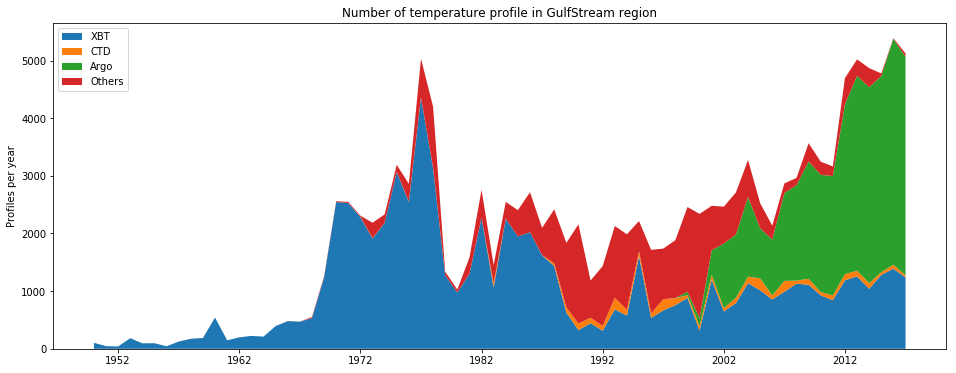

In [9]:
%matplotlib inline
labels=['XBT','CTD','Argo','Others']
plt.figure(figsize=(16,6))
plt.stackplot(nt[0:-1],c1,c2,c3,c4,labels=labels)
plt.ylabel('Profiles per year')
plt.title('Number of temperature profile in Kuroshio region')
plt.legend(loc='upper left')
plt.show()

In [17]:
#CALCULATE MONTLY MEAN WITH ERROR OF FINAL ANOMALY
nt=np.arange('1950-01','2018-02',dtype='datetime64[M]')
PRF=np.empty(len(nt)-1)
for i in range(len(nt)-1):                
    SDAT=DAT.where((DAT.date>=nt[i])&(DAT.date<nt[i+1]),drop=True)
    PRF[i]=SDAT.temp.mean('N_PROF').sum('DEPTH').values/140

<IPython.core.display.Javascript object>


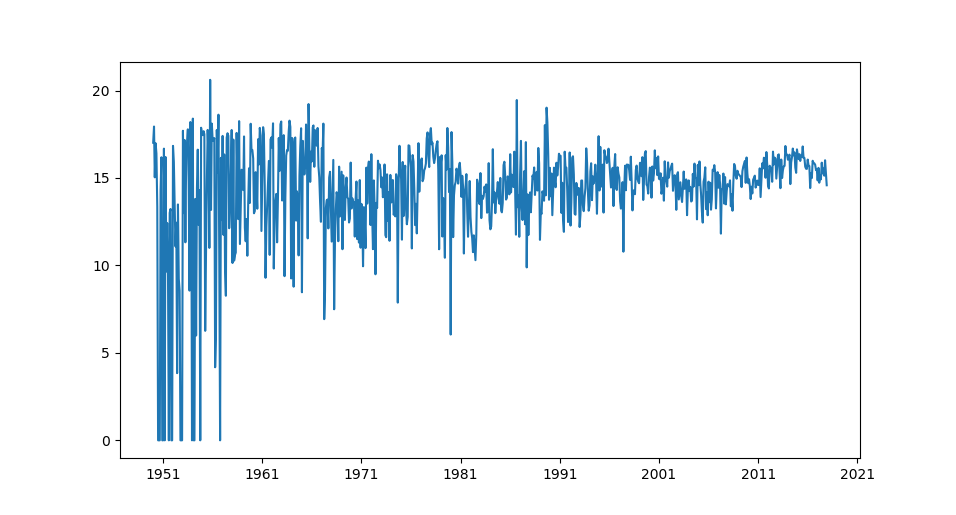

In [18]:
plt.plot(nt[0:-1],PRF)

In [ ]:
#CALCULATE MONTHLY ANO
PRFM=np.empty([12,140])
for k in range(12):
    cond=xr.DataArray((pd.to_datetime(DAT.date.values).month==k+1),dims='N_PROF') 
    PRFM[k,:]==DAT.where(cond,drop=True).temp.mean('N_PROF')

#REMOVE MONTHLY MEAN FROM ANOMALY
DAT=DAT.assign(atemp=DAT.temp)
DAT.atemp.load()
for i in DAT.N_PROF.values:
    tm=pd.to_datetime(DAT.date[i].values).month    
    DAT.atemp[i,:]=DAT.temp[i,:]-PRFM[tm-1,:]       
    

In [53]:
plt.figure()
plt.plot(DAT.date.values,DAT.atemp.mean('DEPTH').values,'-.')

<xarray.DataArray 'atemp' (N_PROF: 137496)>
array([2.357056e+03, 2.407546e+03, 2.520742e+03, ..., 3.589432e+41,
       3.589432e+41, 3.589432e+41])
Dimensions without coordinates: N_PROF

In [42]:
#CALCULATE MONTLY MEAN WITH ERROR OF FINAL ANOMALY
nt=np.arange('1950-01','2018-02',dtype='datetime64[M]')
PRF=np.empty([len(nt)-1,140])
ERF=np.empty(len(nt)-1)
for i in range(len(nt)-1):            
    SDAT=DAT.where((DAT.date>=nt[i])&(DAT.date<nt[i+1]),drop=True)
    PRF[i,:]=SDAT.atemp2.mean('N_PROF')
    ERF[i]=np.mean(np.std(SDAT.atemp2.values,axis=1))/np.sqrt(len(SDAT.N_PROF))
                   

/opt/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


<IPython.core.display.Javascript object>


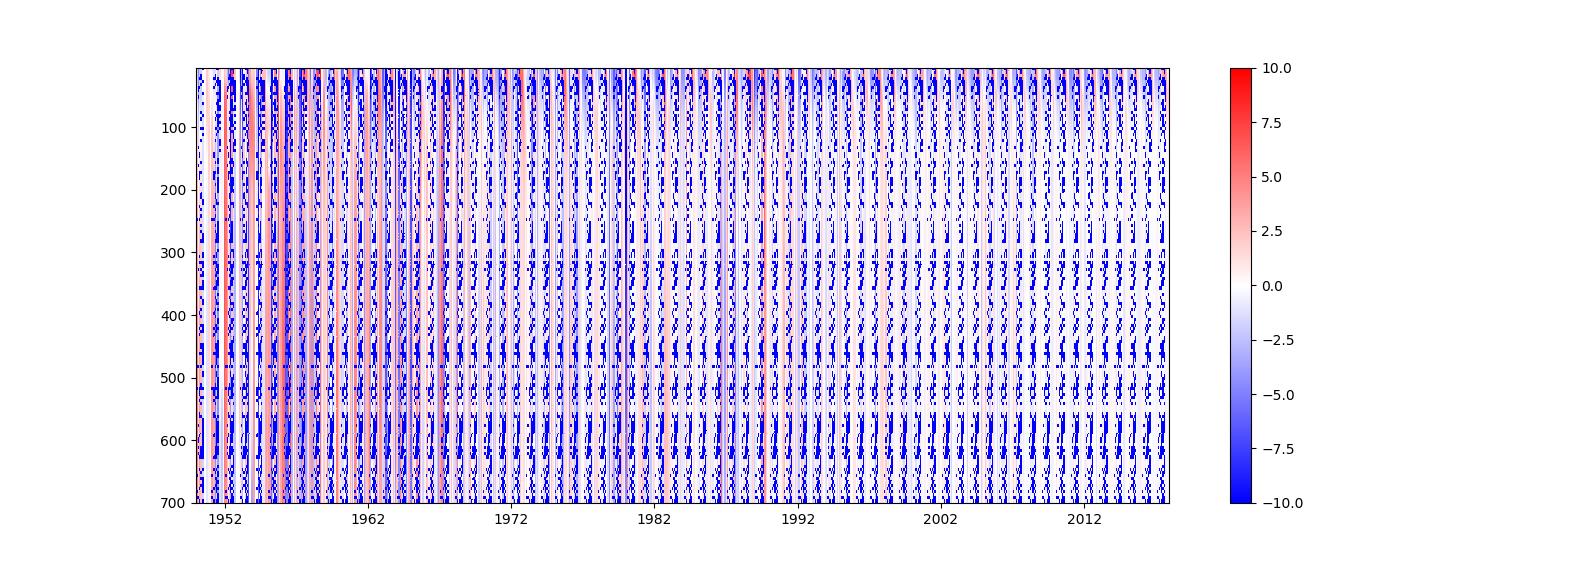

In [48]:
plt.figure()
sc=plt.pcolor(nt[0:-1],DAT.DEPTH,PRF.transpose(),cmap='bwr',vmin=-10,vmax=10)
plt.gca().invert_yaxis()
plt.colorbar(sc)
